In [1]:
import numpy as np
from scipy.special import expit as sigmoid

class My_LSTM:
    
    def __init__(self, weights_fx, weights_fh, curr_x, h_prev, bias_fx, bias_fh, C_t_prev, weights_ix, weights_ih, weights_cx,\
                 weights_ch, weights_ox, weights_oh, bias_ix, bias_ih, bias_cx, bias_ch, bias_ox, bias_oh):
        self.W_fx = weights_fx
        self.W_fh = weights_fh
        self.W_ix = weights_ix
        self.W_ih = weights_ih
        self.W_cx = weights_cx
        self.W_ch = weights_ch
        self.W_ox = weights_ox
        self.W_oh = weights_oh         
        self.X = curr_x
        self.H = h_prev
        self.b_fx = bias_fx
        self.b_fh = bias_fh
        self.b_ix = bias_ix
        self.b_ih = bias_ih
        self.b_cx = bias_cx
        self.b_ch = bias_ch
        self.b_ox = bias_ox
        self.b_oh = bias_oh
        self.C_t_prev = C_t_prev
        
        
    def forget_gate(self):
        return np.multiply(sigmoid((np.dot(self.W_fx, self.X) + self.b_fx) +\
                                   (np.dot(self.W_fh, self.H) + self.b_fh)), self.C_t_prev)
    
    
    def input_gate(self):
        i_t = sigmoid((np.dot(self.W_ix, self.X) + self.b_ix) + (np.dot(self.W_ih, self.H) + self.b_ih))
        C_hat_t = np.tanh((np.dot(self.W_cx, self.X) + self.b_cx) + (np.dot(self.W_ch, self.H) + self.b_ch))
        return np.multiply(i_t, C_hat_t)
        
        
    def cell_state(self, forget_gate_output, input_gate_output):
        return forget_gate_output + input_gate_output


    def output_gate(self):
        out_t = sigmoid((np.dot(self.W_oh, self.H) + self.b_oh) + (np.dot(self.W_ox, self.X) + self.b_ox))
        return np.multiply(out_t, np.tanh(self.cell_state(self.forget_gate(), self.input_gate())))

Epoch 1/3
92/92 - 2s - loss: 0.0067 - 2s/epoch - 17ms/step
Epoch 2/3
92/92 - 0s - loss: 0.0172 - 126ms/epoch - 1ms/step
Epoch 3/3
92/92 - 0s - loss: 0.0132 - 132ms/epoch - 1ms/step
Epoch 1/3
92/92 - 0s - loss: 0.0091 - 128ms/epoch - 1ms/step
Epoch 2/3
92/92 - 0s - loss: 0.0102 - 129ms/epoch - 1ms/step
Epoch 3/3
92/92 - 0s - loss: 0.0093 - 128ms/epoch - 1ms/step
Epoch 1/3
92/92 - 0s - loss: 0.0069 - 128ms/epoch - 1ms/step
Epoch 2/3
92/92 - 0s - loss: 0.0076 - 129ms/epoch - 1ms/step
Epoch 3/3
92/92 - 0s - loss: 0.0075 - 128ms/epoch - 1ms/step
Epoch 1/3
92/92 - 0s - loss: 0.0060 - 130ms/epoch - 1ms/step
Epoch 2/3
92/92 - 0s - loss: 0.0069 - 129ms/epoch - 1ms/step
Epoch 3/3
92/92 - 0s - loss: 0.0070 - 128ms/epoch - 1ms/step
Epoch 1/3
92/92 - 0s - loss: 0.0057 - 128ms/epoch - 1ms/step
Epoch 2/3
92/92 - 0s - loss: 0.0066 - 128ms/epoch - 1ms/step
Epoch 3/3
92/92 - 0s - loss: 0.0067 - 128ms/epoch - 1ms/step
Epoch 1/3
92/92 - 0s - loss: 0.0055 - 128ms/epoch - 1ms/step
Epoch 2/3
92/92 - 0s - los

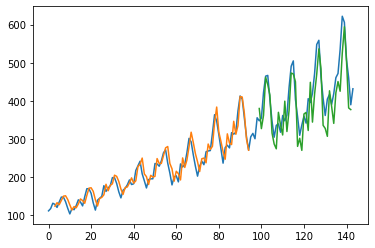

In [2]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

numpy.random.seed(7)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=3, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
